## Gaussian Mixture Model for Density Estimation
This notebook demonstrates Gaussian mixture models (GMMs) in 2D. We can see that the GMM can model quite complicated distributions, but in certain situations be unnecessarily parameterised. 

The approximation of a large GMM (i.e. with a large number of components) with a smaller one is a challenging task. This can be achieved using the well-known Expectation Maximisation algorithm for GMMs as applied to a _sample_ from such a model, but no analytic optimisation procedure is known. A poor-man's version might be the Variational Boosting algorithm (Miller, Foti, and Adams - ICML 2017) which greedily fits Gaussian components via KL minimisation, but this is reasonably expensive and by no means optimal.

The below code generates a random Gaussian mixture, draws samples from it, and then fits a smaller GMM to this synthetic data.

In [3]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [4]:
def gaussian_2D_level_curve(mu, sigma, alpha=2, ncoods=100, plot=True):
    # (Alex Bird 2016)
    # (Ported from my matlab utils / pyalexutil)
    assert isinstance(mu, np.ndarray) and isinstance(sigma, np.ndarray), "mu/sigma must be numpy arrays."
    assert mu.shape == (2, ), 'mu must be vector in R^2'
    assert sigma.shape == (2, 2), 'sigma must be 2x2 array'

    U, S, V = np.linalg.svd(sigma)

    sd = np.sqrt(S)
    coods = np.linspace(0, 2 * np.pi, ncoods)
    coods = np.vstack((sd[0] * np.cos(coods), sd[1] * np.sin(coods))) * alpha

    # project onto basis of ellipse
    coods = (V @ coods).T

    # add mean
    coods += mu

    if plot:
        plt.plot(*coods.T)

    return coods

In [7]:
def gen_mix_mvn(n_components=30, d=2, n_samples=400):
    # Generate random multivariate Gaussians
    pi = np.random.dirichlet([0.8]*n_components)
    mu = np.random.multivariate_normal(np.zeros(d), np.eye(d)*25, size=(n_components))
    mu = np.random.rand(n_components, d) * 10 - 5
    sigma = np.zeros((n_components, d, d))
    for n in range(n_components):
        _tmpmat = np.random.rand(d,d)
        Q, _junk = np.linalg.qr(_tmpmat)
        lam = np.random.exponential(1, d)
        sigma[n] = Q @ np.diag(lam) @ Q.T

    # Draw samples
    z = np.random.multinomial(n_samples, pi)
    smps = np.zeros((n_samples, d))
    indexes = np.stack((np.cumsum(np.concatenate(([0], z[:-1]))),
                        np.cumsum(z)), axis=1)
    for ixs, n, m, s in zip(indexes, z, mu, sigma):
        smps[slice(*ixs)] = np.random.multivariate_normal(m, s, size=n)
    
    return smps, (pi, mu, sigma)

In [145]:
%timeit -n10 gmm.fit(smps)


20.2 ms ± 572 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


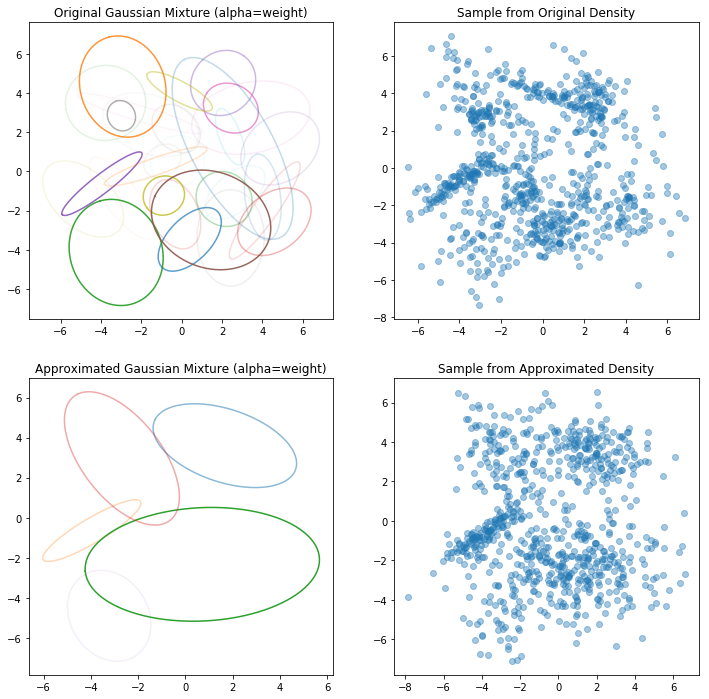

In [85]:
n_components = 30   # number of Gaussians in original mixture
n_approx = 5        # number of Gaussians to approximate with
n_samples = 800     # number of samples to draw from mixture for visualisation.

# generate random Gaussian mixture
smps, pars = gen_mix_mvn(30, n_samples=n_samples)
f, axs = plt.subplots(2, 2)
f.set_size_inches(12,12)

# plot level curves of random Gaussian mixture
axs[0,0].set_title('Original Gaussian Mixture (alpha=weight)')
for pi, m, s in zip(*pars):
    axs[0,0].plot(*gaussian_2D_level_curve(m, s, plot=False).T, alpha=pi/max(pars[0]))

# sample from this Gaussian mixture
axs[0,1].scatter(*smps.T, alpha=0.4)
axs[0,1].set_title('Sample from Original Density')


# fit a new Gaussian mixture with 5 components:
gmm = GaussianMixture(n_components=n_approx)
gmm.fit(smps)

axs[1,0].set_title('Approximated Gaussian Mixture (alpha=weight)')
maxw = max(gmm.weights_)
for pi, m, s in zip(gmm.weights_ ,gmm.means_, gmm.covariances_):
    axs[1,0].plot(*gaussian_2D_level_curve(m, s, plot=False).T, alpha=pi/maxw)


# sample from this Gaussian mixture
smps_approx = gmm.sample(n_samples)[0]
axs[1,1].scatter(*smps_approx.T, alpha=0.4)
axs[1,1].set_title('Sample from Approximated Density');

#### ^^ Above
[**<span style='color:blue'>Top left</span>**] The original (generated) Gaussian mixture. The 2 sigma level curves are drawn (note that this corresponds only to approx 63% of density in 2D) and their weight in the mixture denoted by the alpha value (transparency). Often a fairly large number of low weight components are present (this occurs e.g. in Gaussian Sum filtering).<br>
[**<span style='color:blue'>Top right</span>**] A sample (default: 800) points are drawn from this mixture. The generative model is to choose the component proportionally to the weights, and then draw a sample from the relevant Gaussian. In a certain sense the sample appears less complicated than the original mixture.<br>
[**<span style='color:blue'>Bottom left</span>**] The fitted GMM (using _sklearn_'s version of the EM algorithm). This is implemented reasonably well and converges quickly. However, this may take some time in high dimensions - it is an iterative co-ordinate descent algorithm and is particularly prone to slow convergence if boundaries between components are ill-defined.<br>
[**<span style='color:blue'>Bottom right</span>**] A sample from the approximate GMM. This often appears superficially very similar to the original density and gives credence to the idea that small GMMs are capable of capturing the salient features of complicated densities.

### Comparison with standard Gaussian Sum collapse heuristics

In [93]:
ixs_top4 = np.flip(np.argsort(pars[0]), axis=0)[:n_approx-1]
ixs_other = np.array(list(set(np.argsort(pars[0])) - set(ixs_top4)))
pi_approx = np.concatenate((pars[0][ixs_top4], [sum(pars[0][ixs_other])]))
mu_approx = pars[1][ixs_top4]
mu_other = np.dot(pars[0][ixs_other], pars[1][ixs_other])/pi_approx[-1]
sigma_approx = pars[2][ixs_top4]
sigma_other = -np.outer(mu_other, mu_other)
for i in ixs_other:
    sigma_other += pars[0][i] * (pars[2][i] + np.outer(pars[1][i], pars[1][i]))

mu_approx = np.concatenate((mu_approx, mu_other[None,:]), axis=0)
sigma_approx = np.concatenate((sigma_approx, sigma_other[None,:]), axis=0)

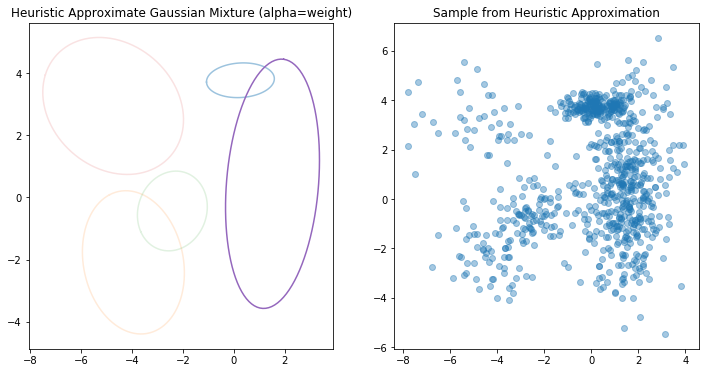

In [20]:
f, axs = plt.subplots(1, 2)
f.set_size_inches(12,6)
# plot level curves of random Gaussian mixture
axs[0].set_title('Heuristic Approximate Gaussian Mixture (alpha=weight)')
for pi, m, s in zip(pi_approx, mu_approx, sigma_approx):
    axs[0].plot(*gaussian_2D_level_curve(m, s, plot=False).T, alpha=pi/max(pi_approx))

# sample from this Gaussian mixture
gmm.means_ = mu_approx; gmm.covariances_ = sigma_approx; gmm.weights_ = pi_approx
smps_approx = gmm.sample(n_samples)[0]
axs[1].scatter(*smps_approx.T, alpha=0.4)
axs[1].set_title('Sample from Heuristic Approximation');

In [152]:
# KL divergence calculation
def calc_prob(x, pars):
    n_dim = len(x)
    n_mix = len(pars[0])
    prob = 0
    for m in range(n_mix):
        sigma_inv = np.linalg.inv(pars[2][m])
        _a = np.exp(-np.dot(x - pars[1][m], np.dot(sigma_inv, x - pars[1][m]))/2)
        _a = _a / (np.sqrt(2*np.pi)**n_dim * np.sqrt(np.linalg.det(pars[2][m])))
        prob += pars[0][m] * _a
    
    return prob


def calc_kl_from_samples(sample, pars1, pars2):
    kl = 0
    for i in sample:
        p = calc_prob(i, pars1)
        q = calc_prob(i, pars2)
        if q > 1e-10:
            kl += p * (np.log(p) - np.log(q))
    return kl
    

In [154]:
approx_pars = (pi_approx, mu_approx, sigma_approx)
em_pars = gmm.weights_, gmm.means_, gmm.covariances_

approx_kl = calc_kl_from_samples(smps, pars, approx_pars)
em_kl = calc_kl_from_samples(smps, pars, em_pars)

In [155]:
from IPython.display import Markdown as md



md(
    
"""
# Comparison

| dimension | Method | KL | Time |
| :---: | :---: | :---: | :---: |
| 2 | EM | {:.5} | {} |
|2 | Barber | {:.5} | {} |""".format(approx_kl, "20ms" , em_kl, 0.00001) )


# Comparison

| dimension | Method | KL | Time |
| :---: | :---: | :---: | :---: |
| 2 | EM | 8.97 | 20ms |
|2 | Barber | 4.4796 | 1e-05 |